In [1]:
!pip install igraph
!pip install scikit-image==0.20.0

     |████████████████████████████████| 13.4 MB 98.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 155.3 MB/s eta 0:00:01
     |████████████████████████████████| 218 kB 156.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 152.1 MB/s eta 0:00:01
     |████████████████████████████████| 43.4 MB 158.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 143.1 MB/s eta 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3


In [2]:
import sys
sys.path.append('../GNEMS')
from GNEMS import GraphicallyGuidedEMSegmentor, GNEMS_segment
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import skimage.util
from PIL import Image
import tqdm
import os
from evaluate import calculate_mIOU
import json
import pandas as pd

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


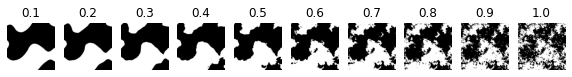

In [3]:
complexities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
image_paths = [path for path in sorted(list(glob("../datasets/edge_complexity/gt/perlin_*_003.png"))) if float(path.split("/")[-1].split("_")[-2]) in complexities]
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i, path in enumerate(image_paths):
    axs[i].imshow(plt.imread(path))
    axs[i].axis('off')
    axs[i].set_title(path.split('_')[-2])

(10, 5, 512, 512)


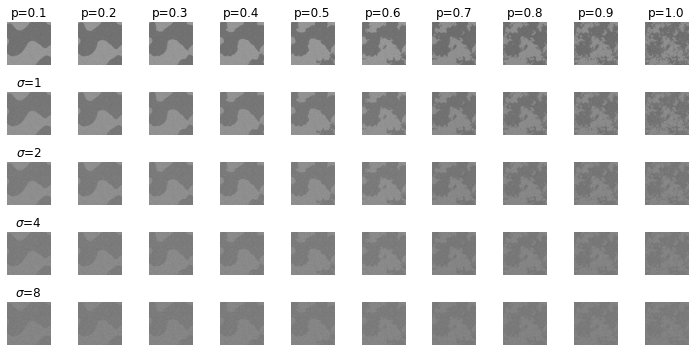

In [4]:
images = np.array([plt.imread(path)[:,:,0] for path in image_paths])
def add_noise(image, amount=0.5, seed=None):
    image = skimage.util.random_noise(image, mode='gaussian', seed=seed, clip=False, var=amount)
    image = image - np.min(image)
    image = image / np.max(image)
    return image
noise_levels = [0.5, 1, 2, 4, 8]
noisy_images = np.array([[add_noise(image, amount=sigma, seed=0) for sigma in noise_levels] for image in images])
fig, axs = plt.subplots(5, 10, figsize=(10, 5))
sigma = r'$\sigma$'
print(noisy_images.shape)
for row in range(noisy_images.shape[0]):
    for col in range(noisy_images.shape[1]):
        axs[col, row].imshow(noisy_images[row, col], cmap='gray')
        axs[col, row].axis('off')
        if row == 0 and col != 0:
            axs[col, row].set_title(f"{sigma}={noise_levels[col]}")
        if col == 0:
            axs[col, row].set_title(f"p={complexities[row]}")
plt.tight_layout()

In [27]:
import concurrent.futures

def segment_and_save(paramset):
    d = paramset["d"]
    sigma = paramset["sigma"]
    p = paramset["p"]
    seed = paramset["seed"]
    bar = paramset["bar"]
    lambda_ = paramset["lambda_"]
    if os.path.exists(f"patch_size_effects_noise_output/d_{d:.1f}_sigma_{sigma:.1f}_p_{p:.1f}_seed_{seed:02d}.png"):
        bar.update(1)
        return
    im = noisy_images[paramset["p_index"], paramset["sigma_index"]]
    seg = GNEMS_segment(im, d=d, lambda_=lambda_,
            iterations=50, prediction_stride=8,
            slic_segments=100, sigma=3, show_progress=False, seed=seed)
    seg = Image.fromarray((seg * 255).astype(np.uint8)).convert('L')
    seg.save(f"patch_size_effects_noise_output/d_{d:.1f}_sigma_{sigma:.1f}_p_{p:.1f}_seed_{seed:02d}.png")
    bar.update(1)

d_values = [4, 8, 16, 32, 64]
seeds = list(range(20,100))
paramsets = []
with tqdm.tqdm(total=noisy_images.shape[0] * noisy_images.shape[1] * len(d_values) * len(seeds)) as pbar:
    for d in d_values:
        for sigma_index, sigma in enumerate(noise_levels):
            for p_index, p in enumerate(complexities):
                for seed in seeds:
                        paramsets.append({"bar":pbar,"d":d, "sigma":sigma, "sigma_index":sigma_index, "p":p, "p_index":p_index, "lambda_":0.3, "seed":seed})

    with concurrent.futures.ThreadPoolExecutor(max_workers=60) as executor:
        res = executor.map(segment_and_save, paramsets)
    for result in res:
        pass
            

100%|██████████| 20000/20000 [2:02:51<00:00,  2.71it/s]  


In [28]:
segmentation_paths = sorted(list(glob("patch_size_effects_noise_output/*.png")))
ds = []
sigmas = []
ps = []
mious = []
seeds = []
for path in tqdm.tqdm(segmentation_paths):
    split_name = ".".join(path.split('/')[-1].split(".")[:-1]).split("_")
    d = float(split_name[1])
    sigma = float(split_name[3])
    p = float(split_name[5])
    seed = int(split_name[7])
    gt_path = f"../datasets/edge_complexity/gt/perlin_{p:.1f}_003.png"
    gt = plt.imread(gt_path)[:,:,0]
    seg = plt.imread(path)
    miou = calculate_mIOU(seg, gt)
    ds.append(d)
    sigmas.append(sigma)
    ps.append(p)
    mious.append(miou)
    seeds.append(seed)

results = np.array([ds, sigmas, ps, mious, seeds]).T

with open("patch_size_effects_results.json", "w") as f:
    json.dump(results.tolist(), f)

100%|██████████| 25000/25000 [20:22<00:00, 20.45it/s]


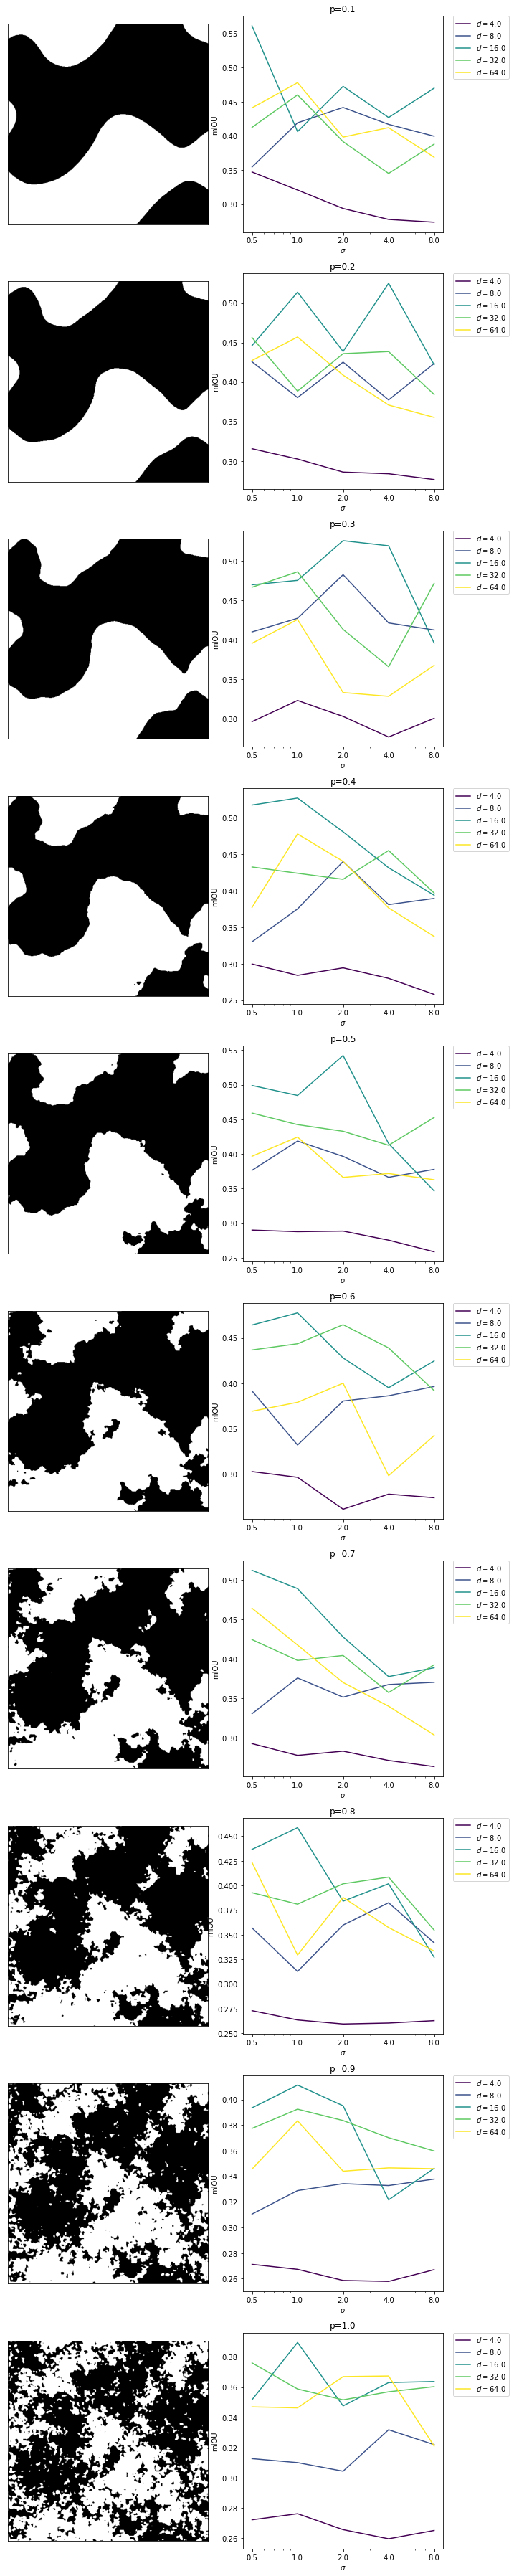

In [31]:
with open("patch_size_effects_results.json", "r") as f:
    results = np.array(json.load(f))
sigmas = np.unique(results[:,1])
df = pd.DataFrame(results, columns=["d", "sigma", "p", "mIOU", "seeds"])
colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(ds))))
fig, axs = plt.subplots(10, 2, figsize=(10, 50))
for i, p in enumerate(complexities):
    df_p = df[df["p"] == p]
    for d_index, d in enumerate(np.unique(ds)):
        df_d = df_p[df_p["d"] == d]
        d_sigmas = []
        d_mIOU_means = []
        d_mIOU_stds = []
        for sigma in np.unique(sigmas):
            df_sigma = df_d[df_d["sigma"] == sigma]
            d_sigmas.append(sigma)
            d_mIOU_means.append(df_sigma["mIOU"].mean())
            d_mIOU_stds.append(df_sigma["mIOU"].std())
        axs[i,1].plot(d_sigmas, d_mIOU_means, label=f"$d={d}$", color=colors[d_index])
        # axs[i,1].fill_between(d_sigmas, np.array(d_mIOU_means) - np.array(d_mIOU_stds), np.array(d_mIOU_means) + np.array(d_mIOU_stds), alpha=0.2, color=colors[d_index])
    axs[i,1].set_title(f"p={p}")
    axs[i,1].set_xlabel(r"$\sigma$")
    axs[i,1].set_ylabel("mIOU")
    axs[i,1].set_xscale('log')
    axs[i,1].set_xticks(sigmas)
    axs[i,1].set_xticklabels(sigmas)
    axs[i,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[i,0].imshow(plt.imread(f"../datasets/edge_complexity/gt/perlin_{p:.1f}_003.png")[:,:,0], cmap='gray')
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
plt.tight_layout()